<a href="https://colab.research.google.com/github/AndreiLesi/Data-Engineering/blob/master/churnAnalysis_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Churn Analysis - using Spark**

### **Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

### **Content**

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents




## Initialize Spark

In [ ]:
# Note: This is only required in Google Colab to install pyspark
!pip install -q pyspark

In [2]:
import pyspark
import random
from pyspark.sql import SparkSession
from pyspark.sql.types import *

spark = SparkSession.builder.appName("PySpark").getOrCreate()
sc = pyspark.SparkContext.getOrCreate()

## Imports

In [ ]:
import pandas as pd
import seaborn as sns      
sns.set(style="darkgrid")
from pyspark import SparkFiles
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,\
                               Imputer
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

## Load Data

In [4]:
# Read Dataset
url = "https://raw.githubusercontent.com/treselle-systems/" + \
      "customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv"

spark.sparkContext.addFile(url)

df = spark.read.option("inferSchema", True) \
    .option("header", True) \
    .option("nanValue", " ") \
    .option("nullValue", " ") \
    .csv("file://"+SparkFiles.get("WA_Fn-UseC_-Telco-Customer-Churn.csv"))

In [5]:
# Dataframe Bassic Information
df.printSchema()
df.show(10)
display("Number of Entries: " + str(df.count()))

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)

+----------+------+-------------+-------+----------+------+------------+---------

'Number of Entries: 7043'

## Analyze Data

In [6]:
# Check if Null Values exist
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()
# ==> In TotalCharges, 11 Rows are None, we will replace those later on

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



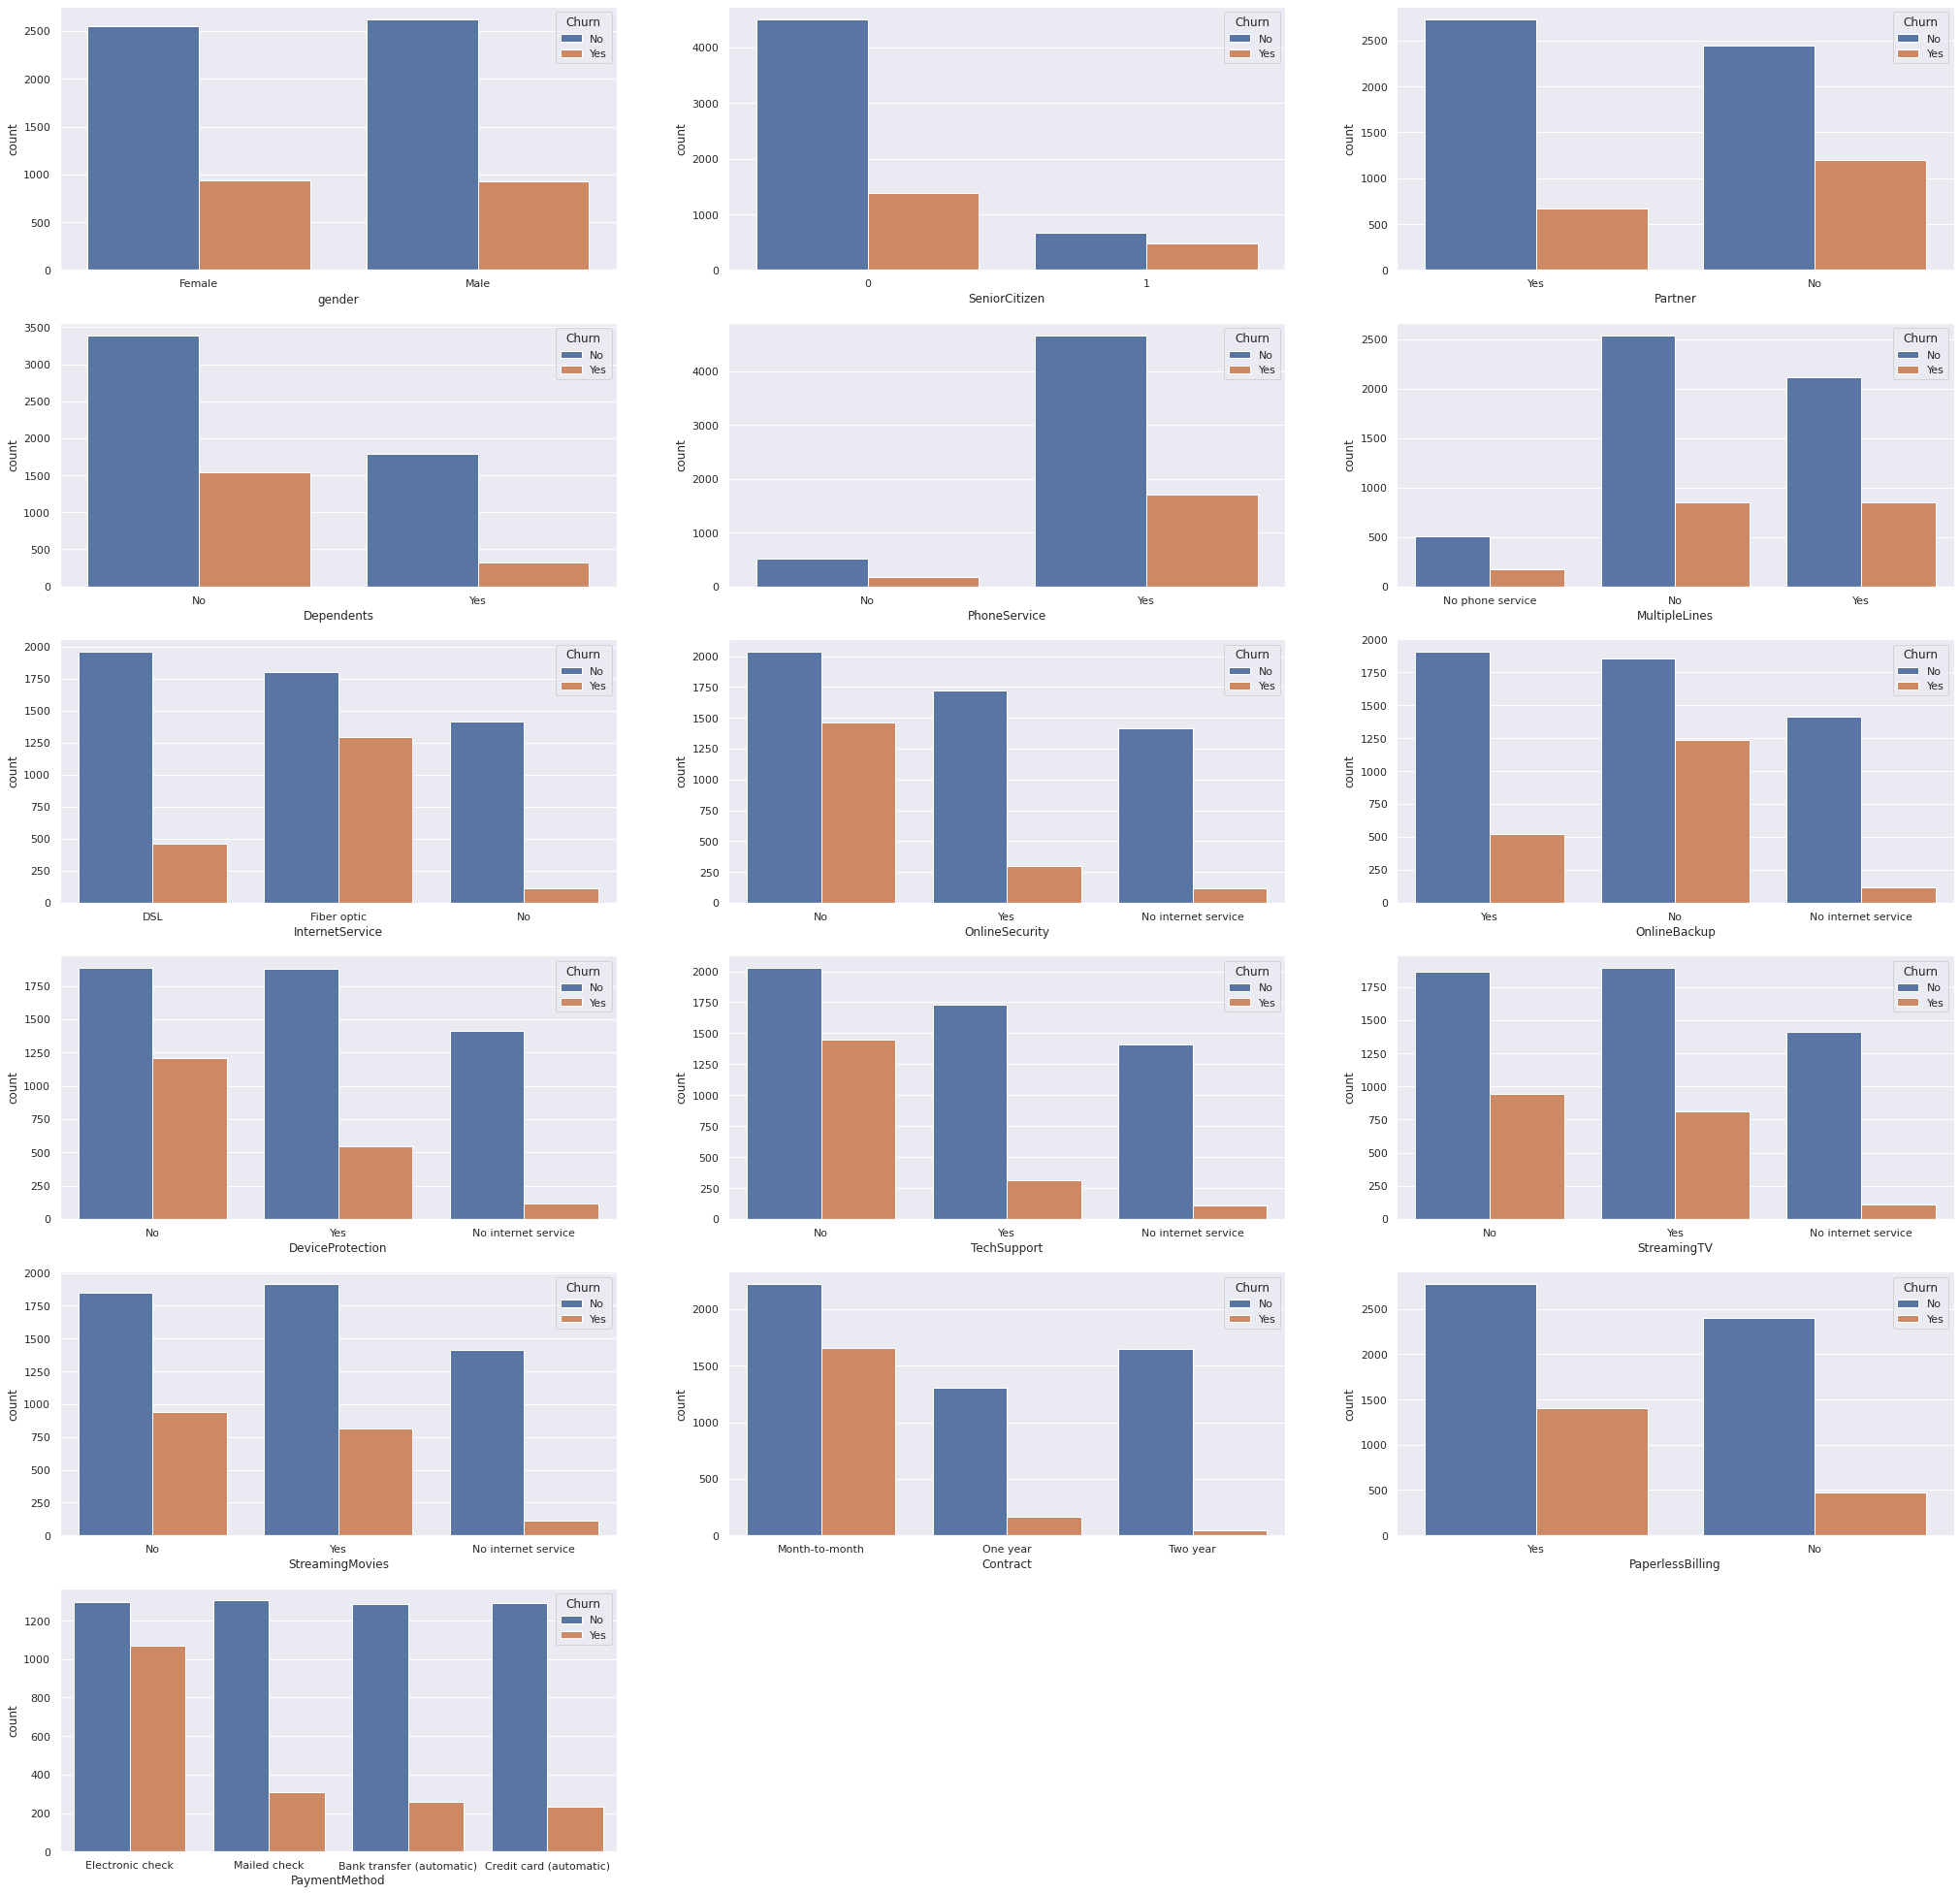

In [7]:
# Analyze categorical columns -> use df.columns to find out which one there is
catColumns = ["gender", "SeniorCitizen", 'Partner', 'Dependents', 'PhoneService'
              ,'MultipleLines', 'InternetService', 'OnlineSecurity', 
              'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
              'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'
              ]

# See if dataset is balanced or not -> here unbalanced
df.groupBy("Churn").count().show()

# Plot all categorical columns
df_pd = df.toPandas()
fig, ax = plt.subplots(6,3, figsize=(35,35))
axlist = [val for sublist in ax for val in sublist]
ax[-1, -1].axis('off')
ax[-1, -2].axis('off')
for i in range(len(catColumns)):
  sns.countplot(x=catColumns[i], hue="Churn", data = df_pd, ax = axlist[i])

In [ ]:
# Alternatively Analyze Pivot Tables
for col in catColumns:
 display(df_pd[[col,"Churn"]].groupby([col, "Churn"])["Churn"].count().to_frame\
         ("count").reset_index().pivot(index = col, columns = "Churn"))
 
# Note to print information use the inbuild spark commands as follows:
# df.select("gender","churn").groupBy("gender","churn").count().show()

+-------+------------------+------------------+------------------+
|summary|            tenure|      TotalCharges|    MonthlyCharges|
+-------+------------------+------------------+------------------+
|  count|              7043|              7032|              7043|
|   mean| 32.37114865824223|2283.3004408418697| 64.76169246059922|
| stddev|24.559481023094442| 2266.771361883145|30.090047097678482|
|    min|                 0|              18.8|             18.25|
|    max|                72|            8684.8|            118.75|
+-------+------------------+------------------+------------------+



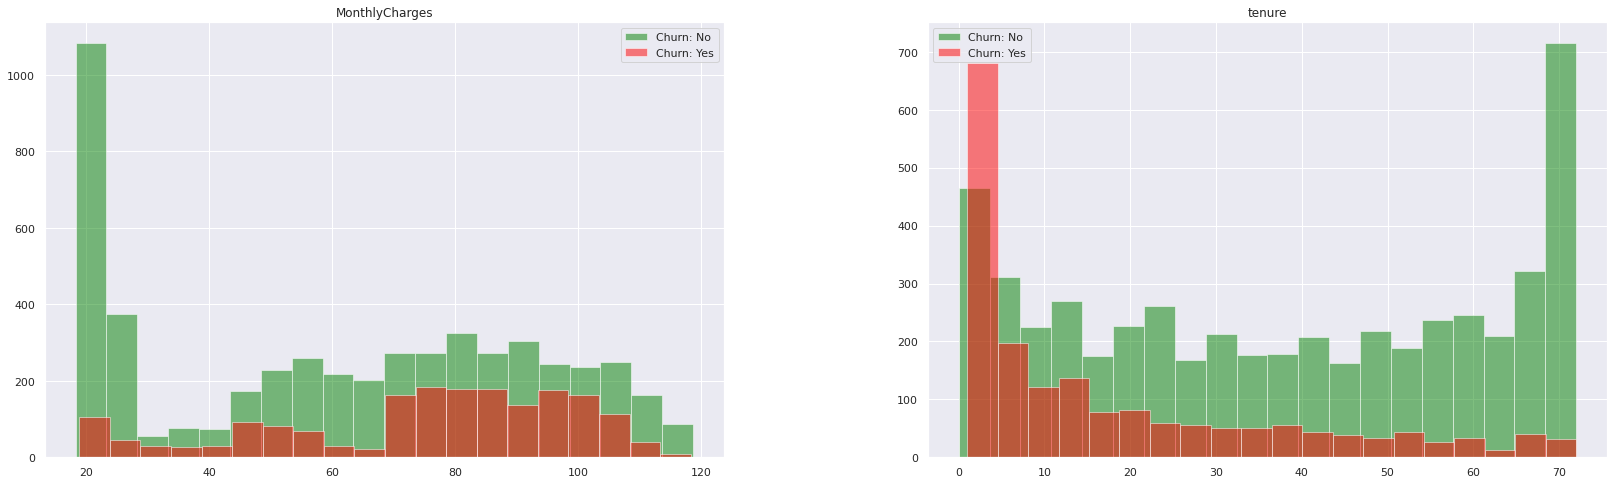

In [12]:
# Analyze the numeric columns:
df.select("tenure", "TotalCharges", "MonthlyCharges").describe().show()

df_pd = df.select("tenure", "MonthlyCharges", "Churn").toPandas()
fig, ax = plt.subplots(1, 2, figsize=(28, 8))
df_pd[df_pd.Churn == 'No'].hist(bins=20, color="green", alpha=0.5, 
                                ax=ax, label="Churn: No")
df_pd[df_pd.Churn == "Yes"].hist(bins=20, color="red", alpha=0.5, 
                                 ax=ax, label="Churn: Yes")
ax[0].legend()
ax[1].legend()

## Create and run the pre-processing pipeline

In [ ]:
# Convert Categorical coloums into number using a string encoder and OHE
stages = []

for category in catColumns:
  stringIndexer = StringIndexer(inputCol = category, 
                                outputCol = category + "Index")
  OHE = OneHotEncoder(inputCol= stringIndexer.getOutputCol(), 
                      outputCol = category + "CatVec")
  stages += [stringIndexer, OHE]

# Fix missing input -> as we saw there are some entries missing in TotalCharges.
# These inputs can be estimated using Linear regerssion -> use Imputer here
imputer = Imputer(inputCol= "TotalCharges", outputCol = "out_TotalCharges")
stages += [imputer]

# Finally convert label -> churn YES/NO to 0/1 using a string indexer
label_Idx = StringIndexer(inputCol = "Churn", outputCol = "label")
stages += [label_Idx]

# create feature Vector using VectorAssembler
numericCols = ["tenure", "out_TotalCharges", "MonthlyCharges"]
assembleInputs = [c + "CatVec" for c in catColumns] + numericCols
assembler = VectorAssembler(inputCols = assembleInputs, outputCol = "features")
stages += [assembler]

# Final Stages summary:
stages

In [14]:
# Split data into train and test, with a seed of 24 -> ensures same split
(train_data, test_data) = df.randomSplit([0.7, 0.3], 24)

# Create pipeline and run it on training data
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train_data)

# Transform Training and Test Data -> Append new categorical and num columns
trainprepDF = pipelineModel.transform(train_data)
testprepDF = pipelineModel.transform(test_data)

# Finally we the data preprocesssing is finished, the end-result is a 30-dim
# features vector and a numerical labels vector necesarry for training the LR
trainprepDF.printSchema()
trainprepDF.show(2)

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)
 |-- genderIndex: double (nullable = false)
 |-- genderCatVec: vector (nullable = 

## Create and Evaluate Model with HyperParameter Tuning


In [15]:
# Use a Logistic Regression for predictions. By default the Model expects
# featuresCol = "features" and labelCol = 'label' as is the case here
lr = LogisticRegression()
evaluatorLR = BinaryClassificationEvaluator()

# Perform CrossValidation and look for the best parameter combination
# Create Parameter Grid for Cross Validation
paramGrid = (ParamGridBuilder()
            .addGrid(lr.regParam, [0.01, 0.5, 2.0])
            .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
            .addGrid(lr.maxIter, [25, 50, 75])
            .build())

# Use 5-Fold CrossValidation to test the parameter combinations
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                    evaluator = evaluatorLR)
cvModel = cv.fit(trainprepDF)

Accuracy: 0.8106029947389721
FPR: 0.3671934472971666
TPR: 0.8106029947389721
F-Measure: 0.8027679939368022
Precision: 0.8012446507082334
Recall: 0.8106029947389721
AreaUnderRoc: 0.8522087743285899



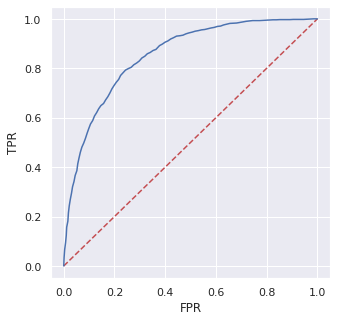

In [16]:
# Analyze Logistic Regression Results for the Training Dataset
summary = cvModel.bestModel.summary
accuracy = summary.accuracy
falsePositiveRate = summary.weightedFalsePositiveRate
truePositiveRate = summary.weightedTruePositiveRate
fMeasure = summary.weightedFMeasure()
precision = summary.weightedPrecision
recall = summary.weightedRecall
AreaUnderROC = summary.areaUnderROC

print(("Accuracy: %s\nFPR: %s\nTPR: %s\nF-Measure: %s\nPrecision: %s\nRecall: "
       "%s\nAreaUnderRoc: %s\n") % (accuracy, falsePositiveRate, 
                                    truePositiveRate, fMeasure, precision, 
                                    recall,AreaUnderROC))

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(summary.roc.select('FPR').collect(),
         summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [17]:
# Evaluate Logistic Regression using the Testing Dataset
predictions = cvModel.bestModel.transform(testprepDF)
# The transform method appends 3 new columns to the DF using the LR data, 
# namely RawPred, Prob, Pred. Therefore it is also possible to add the LogReg 
# to the Pipeline!
evaluatorLR = BinaryClassificationEvaluator()
area_under_curve = evaluatorLR.evaluate(predictions)
print("Log. Reg. Test Performance: " + str(area_under_curve))

Log. Reg. Test Performance: 0.8286781224634312


## Test a Different Classifier

In [18]:
rf = RandomForestClassifier()

paramGrid = (ParamGridBuilder()
            .addGrid(rf.impurity, ["gini", "entropy"])
            .addGrid(rf.numTrees, [20, 40, 60])
            .addGrid(rf.maxDepth, [5, 10, 15])
            .build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, 
                    evaluator = evaluatorLR)
cvModel = cv.fit(trainprepDF)

In [19]:
# Evaluate Logistic Regression using the Testing Dataset
predictions = cvModel.bestModel.transform(testprepDF)
evaluatorLR = BinaryClassificationEvaluator()
area_under_curve = evaluatorLR.evaluate(predictions)
print("Random Forest Test Performance: " + str(area_under_curve))

Random Forest Test Performance: 0.8300399642207517
